In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [2]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import json
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import gensim.downloader as api

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
word_vectors = api.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [5]:
def create_word_to_pos(data):
    word_to_pos = {}
    for entry in data:
        tokens = entry["token"]
        pos_tags = nltk.pos_tag(tokens)
        for token, pos in pos_tags:
            if token not in word_to_pos:
                word_to_pos[token] = pos
    return word_to_pos

In [6]:
def process_data(data):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    tokens_list = []
    aspects_list = []
    bio_tags_list = []
    token_length_list = []
    pos_tags_list = []

    for entry in data:
        tokens = entry["token"]
        aspects = entry.get("aspects", [])
        pos_tags = nltk.pos_tag(tokens)

        unique_aspects = [aspect["term"][0] for aspect in aspects]
        bio_tags = ['O'] * len(tokens)

        for aspect in aspects:
            term = aspect.get("term", [])
            for i in range(len(tokens)):
                if tokens[i:i + len(term)] == term:
                    if i > 0 and bio_tags[i - 1] == 'B':
                        bio_tags[i] = 'I'
                    else:
                        bio_tags[i] = 'B'
                    if len(term) > 1:
                        bio_tags[i + 1:i + len(term)] = ['I'] * (len(term) - 1)
        # Removing stopwords and punctuation after tagging
        filtered_tokens = []
        filtered_bio_tags = []
        filtered_pos_tags = []
        for i, token in enumerate(tokens):
            if token.lower() not in stop_words and token not in punctuation:
                filtered_tokens.append(token)
                filtered_bio_tags.append(bio_tags[i])
                filtered_pos_tags.append(pos_tags[i][1])

        tokens_list.append(filtered_tokens)
        aspects_list.append(unique_aspects)
        bio_tags_list.append(filtered_bio_tags)
        token_length_list.append([len(token) for token in filtered_tokens])
        pos_tags_list.append(filtered_pos_tags)
    df_result = pd.DataFrame({
        'token': tokens_list,
        'aspect': aspects_list,
        'bioTag': bio_tags_list,
        'token_length': token_length_list,
        'pos': pos_tags_list
    })

    return df_result

In [7]:
import nltk
import pandas as pd
import string
from nltk.corpus import stopwords

def process_data(data):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    tokens_list = []
    aspects_list = []
    bio_tags_list = []
    token_length_list = []
    pos_tags_list = []

    for entry in data:
        tokens = [token for token in entry["token"] if token not in punctuation]
        aspects = entry.get("aspects", [])
        pos_tags = nltk.pos_tag(tokens)

        unique_aspects = []
        bio_tags = ['O'] * len(tokens)

        for aspect in aspects:
            term = [char for char in aspect.get("term", []) if char not in punctuation]
            unique_aspects.append(''.join(term))

            for i in range(len(tokens)):
                if tokens[i:i + len(term)] == term:
                    if i > 0 and bio_tags[i - 1] == 'B':
                        bio_tags[i] = 'I'
                    else:
                        bio_tags[i] = 'B'
                    if len(term) > 1:
                        bio_tags[i + 1:i + len(term)] = ['I'] * (len(term) - 1)

        filtered_tokens = tokens
        filtered_bio_tags = bio_tags
        filtered_pos_tags = [tag[1] for tag in pos_tags]

        tokens_list.append(filtered_tokens)
        aspects_list.append(unique_aspects)
        bio_tags_list.append(filtered_bio_tags)
        token_length_list.append([len(token) for token in filtered_tokens])
        pos_tags_list.append(filtered_pos_tags)

    df_result = pd.DataFrame({
        'token': tokens_list,
        'aspect': aspects_list,
        'bioTag': bio_tags_list,
        'token_length': token_length_list,
        'pos': pos_tags_list
    })

    return df_result


### Load Dataset


In [8]:
# Load training data from JSON file
train_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/train.json'
with open(train_json_file_path, 'r') as file:
    train_data = json.load(file)
test_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/test.json'
with open(test_json_file_path, 'r') as file:
    test_data = json.load(file)
valid_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/valid.json'
with open(valid_json_file_path, 'r') as file:
    valid_data = json.load(file)

In [9]:
df_train = process_data(train_data)
df_test = process_data(test_data)
df_valid = process_data(valid_data)

In [10]:
df_train

,token,aspect,bioTag,token_length,pos
0,"[I, charge, it, at, night, and, skip, taking, ...","[cord, batterylife]","[O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, ...","[1, 6, 2, 2, 5, 3, 4, 6, 3, 4, 4, 2, 7, 2, 3, ...","[PRP, VBP, PRP, IN, NN, CC, NN, VBG, DT, NN, I..."
1,"[The, tech, guy, then, said, the, service, cen...","[servicecenter, ``sales''team, techguy]","[O, B, I, O, O, O, B, I, O, O, O, O, O, O, O, ...","[3, 4, 3, 4, 4, 3, 7, 6, 4, 3, 2, 6, 8, 3, 1, ...","[DT, NN, NN, RB, VBD, DT, NN, NN, VBZ, RB, VB,..."
2,"[it, is, of, high, quality, has, a, killer, GU...","[quality, GUI, applications, use]","[O, O, O, O, B, O, O, O, B, O, O, O, O, O, O, ...","[2, 2, 2, 4, 7, 3, 1, 6, 3, 2, 9, 6, 2, 6, 10,...","[PRP, VBZ, IN, JJ, NN, VBZ, DT, NN, NNP, VBZ, ..."
3,"[Easy, to, start, up, and, does, not, overheat...",[startup],"[O, O, B, I, O, O, O, O, O, O, O, O, O]","[4, 2, 5, 2, 3, 4, 3, 8, 2, 4, 2, 5, 7]","[NNP, TO, VB, RP, CC, VBZ, RB, VB, RB, JJ, IN,..."
4,"[I, even, got, my, teenage, son, one, because,...","[features, iChat, Photobooth, garageband]","[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[1, 4, 3, 2, 7, 3, 3, 7, 2, 3, 8, 4, 2, 6, 4, ...","[PRP, RB, VBD, PRP$, NN, NN, CD, IN, IN, DT, N..."
...,...,...,...,...,...
1449,"[Thus, when, you, carry, it, at, a, slanted, a...",[screen],"[O, O, O, O, O, O, O, O, O, O, B, O, O, O, O, ...","[4, 4, 3, 5, 2, 2, 1, 7, 5, 3, 6, 4, 2, 6, 2, ...","[RB, WRB, PRP, VBP, PRP, IN, DT, JJ, NN, DT, N..."
1450,"[It, 's, now, all, commodity, hardware]",[commodityhardware],"[O, O, O, O, B, I]","[2, 2, 3, 3, 9, 8]","[PRP, VBZ, RB, DT, NN, NN]"
1451,"[We, also, use, Paralles, so, we, can, run, vi...","[Paralles, WindowsXPProfessional, Windows7Home...","[O, O, O, B, O, O, O, O, O, O, O, B, I, I, B, ...","[2, 4, 3, 8, 2, 2, 3, 3, 7, 8, 2, 7, 2, 12, 7,...","[PRP, RB, VBP, NNS, IN, PRP, MD, VB, JJ, NNS, ..."
1452,"[How, Toshiba, handles, the, repair, seems, to...",[repair],"[O, O, O, O, B, O, O, O, O, O, O, O, O, O, O, ...","[3, 7, 7, 3, 6, 5, 2, 4, 4, 5, 8, 4, 4, 4, 7, ...","[WRB, NNP, VBZ, DT, NN, VBZ, TO, VB, DT, NNS, ..."


### Create a tokenizer and fit on the tokenized sentences in the training data

In [11]:
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['token'])
max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2}

In [12]:
# Pad sequences with the fixed maximum sequence length
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['token']), maxlen=max_seq_length, padding='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['token']), maxlen=max_seq_length, padding='post')
X_val = pad_sequences(tokenizer.texts_to_sequences(df_valid['token']), maxlen=max_seq_length, padding='post')

# Pad BIO tag sequences with the fixed maximum sequence length
y_train = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train['bioTag']], padding='post', value=tag_to_index['O'], maxlen=max_seq_length)
y_test = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test['bioTag']], padding='post', value=tag_to_index['O'], maxlen=max_seq_length)
y_val = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid['bioTag']], padding='post', value=tag_to_index['O'], maxlen=max_seq_length)

# Convert numerical representations to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)


### Create embedding matrix

In [13]:
embedding_dim = 200  # Adjust based on the GloVe file you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

#### Define the BiLSTM model

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

def create_model(embedding_matrix, max_seq_length):
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1],
                        input_length=max_seq_length, weights=[embedding_matrix], trainable=True, mask_zero=True))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
    model.add(TimeDistributed(Dense(128, activation='tanh')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(3, activation='softmax')))
    return model

In [16]:
# Create and compile the model
model = create_model(embedding_matrix, max_seq_length)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20, callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/20
46/46 [==============================] - 47s 778ms/step - loss: 0.3988 - accuracy: 0.8625 - val_loss: 0.3448 - val_accuracy: 0.8676
Epoch 2/20
46/46 [==============================] - 39s 859ms/step - loss: 0.2194 - accuracy: 0.9219 - val_loss: 0.2546 - val_accuracy: 0.9050
Epoch 3/20
46/46 [==============================] - 34s 737ms/step - loss: 0.1476 - accuracy: 0.9486 - val_loss: 0.2058 - val_accuracy: 0.9208
Epoch 4/20
46/46 [==============================] - 37s 819ms/step - loss: 0.1059 - accuracy: 0.9648 - val_loss: 0.1957 - val_accuracy: 0.9284
Epoch 5/20
46/46 [==============================] - 34s 735ms/step - loss: 0.0773 - accuracy: 0.9739 - val_loss: 0.2157 - val_accuracy: 0.9287
Epoch 6/20
46/46 [==============================] - 37s 807ms/step - loss: 0.0593 - accuracy: 0.9800 - val_loss: 0.2430 - val_accuracy: 0.9251
Epoch 7/20
13/13 [==============================] - 2s 163ms/step - loss: 0.1957 - accuracy: 0.9284
Test Loss: 0.195699080824852
Test Accuracy

In [17]:
from sklearn.metrics import classification_report

# Predictions on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Generate classification report
report = classification_report(y_true_labels.flatten(), y_pred_labels.flatten(), labels=[0,1, 2], target_names=['O' ,'B', 'I'])
print(report)

13/13 [==============================] - 6s 166ms/step
              precision    recall  f1-score   support

           O       1.00      1.00      1.00     80752
           B       0.78      0.76      0.77       623
           I       0.84      0.61      0.71       425

    accuracy                           0.99     81800
   macro avg       0.87      0.79      0.83     81800
weighted avg       0.99      0.99      0.99     81800



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels.flatten(), y_pred_labels.flatten(), labels=[0, 1, 2])

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1_score)

Overall Precision: [0.99650423 0.79928952 0.82624113]
Overall Recall: [0.99900931 0.7223114  0.54823529]
Overall F1-score: [0.9977552  0.75885329 0.65912306]


In [18]:
from sklearn.metrics import accuracy_score

# Filter out 'O' tag predictions and true labels
non_O_indices = np.where(y_true_labels.flatten() != 0)
y_true_non_O = y_true_labels.flatten()[non_O_indices]
y_pred_non_O = y_pred_labels.flatten()[non_O_indices]

# Calculate overall accuracy ignoring 'O' tag
overall_accuracy_non_O = accuracy_score(y_true_non_O, y_pred_non_O)

# Print overall accuracy ignoring 'O' tag
print("Overall Accuracy (excluding 'O' tag):", overall_accuracy_non_O)


Overall Accuracy (excluding 'O' tag): 0.7013358778625954


In [19]:
from sklearn.metrics import classification_report

# Predictions on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Generate classification report
report = classification_report(y_true_labels.flatten(), y_pred_labels.flatten(), labels=[1, 2], target_names=['B', 'I'])
print(report)

13/13 [==============================] - 4s 305ms/step
              precision    recall  f1-score   support

           B       0.78      0.76      0.77       623
           I       0.84      0.61      0.71       425

   micro avg       0.80      0.70      0.75      1048
   macro avg       0.81      0.69      0.74      1048
weighted avg       0.80      0.70      0.75      1048



In [22]:
from keras.models import Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, Input, Concatenate, Dot
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.layers import Activation, RepeatVector, Permute, multiply, Lambda
from keras import backend as K


def create_model_with_attention(embedding_matrix, max_seq_length):
    input_layer = Input(shape=(max_seq_length,))
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                input_length=max_seq_length,
                                weights=[embedding_matrix],
                                trainable=True, mask_zero=True)(input_layer)  # Consider setting trainable=True for fine-tuning
    dropout_emb = Dropout(0.5)(embedding_layer)

    # Attention Mechanism
    attention = TimeDistributed(Dense(512, activation='relu'))(dropout_emb)
    attention = TimeDistributed(Dense(1))(attention)
    attention = TimeDistributed(Dense(128, activation='relu'))(attention)
    attention = TimeDistributed(Dense(1))(attention)
    # attention = TimeDistributed(Dense(64, activation='relu'))(attention)
    # attention = TimeDistributed(Dense(1))(attention)
    attention = Activation('softmax')(attention)

    # Apply attention weights
    sent_representation = multiply([dropout_emb, attention])
    lstm = Bidirectional(LSTM(units=100, return_sequences=True))(sent_representation)

    # Self-Attention Mechanism
    self_attention = Dot(axes=[2, 2])([lstm, lstm])
    self_attention = Activation('softmax')(self_attention)

    # Combine attention and self-attention
    combined_attention = Concatenate(axis=-1)([lstm, self_attention])

    # Feedforward layer
    output = TimeDistributed(Dense(128, activation='tanh'))(combined_attention)
    output = Dropout(0.2)(output)
    output = TimeDistributed(Dense(3, activation='softmax'))(output)  # Assuming 3 classes: 'O', 'B', 'I'

    model = Model(inputs=input_layer, outputs=output)

    return model
# Create and compile the model with attention mechanisms
model_attention = create_model_with_attention(embedding_matrix, max_seq_length)
model_attention.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_attention = model_attention.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20, callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model_attention.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_attention = model_attention.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels_attention = np.argmax(y_pred_attention, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

report_attention = classification_report(y_true_labels.flatten(), y_pred_labels_attention.flatten(), labels=[0, 1, 2], target_names=['O', 'B', 'I'])
print(report_attention)


Epoch 1/20
46/46 [==============================] - 59s 1s/step - loss: 0.4149 - accuracy: 0.8623 - val_loss: 0.3728 - val_accuracy: 0.8566
Epoch 2/20
46/46 [==============================] - 44s 953ms/step - loss: 0.2581 - accuracy: 0.9055 - val_loss: 0.2654 - val_accuracy: 0.9001
Epoch 3/20
46/46 [==============================] - 46s 995ms/step - loss: 0.1994 - accuracy: 0.9295 - val_loss: 0.2215 - val_accuracy: 0.9143
Epoch 4/20
46/46 [==============================] - 53s 1s/step - loss: 0.1677 - accuracy: 0.9400 - val_loss: 0.2010 - val_accuracy: 0.9214
Epoch 5/20
46/46 [==============================] - 45s 977ms/step - loss: 0.1470 - accuracy: 0.9474 - val_loss: 0.2192 - val_accuracy: 0.9190
Epoch 6/20
46/46 [==============================] - 43s 933ms/step - loss: 0.1288 - accuracy: 0.9544 - val_loss: 0.1949 - val_accuracy: 0.9260
Epoch 7/20
46/46 [==============================] - 46s 999ms/step - loss: 0.1185 - accuracy: 0.9564 - val_loss: 0.1992 - val_accuracy: 0.9265
Epoch

In [23]:
from sklearn.metrics import precision_recall_fscore_support
# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels.flatten(),  y_pred_labels_attention.flatten(), labels=[0, 1, 2], average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1_score)

from sklearn.metrics import classification_report

# Predictions on test data
y_pred = model.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

# Generate classification report
report = classification_report(y_true_labels.flatten(), y_pred_labels_attention.flatten(), labels=[1, 2], target_names=['B', 'I'])
print(report)


Overall Precision: 0.99485829740678
Overall Recall: 0.995158924205379
Overall F1-score: 0.9949460624940978
13/13 [==============================] - 5s 357ms/step
              precision    recall  f1-score   support

           B       0.83      0.76      0.79       623
           I       0.82      0.65      0.73       425

   micro avg       0.83      0.72      0.77      1048
   macro avg       0.83      0.71      0.76      1048
weighted avg       0.83      0.72      0.77      1048



In [25]:
from sklearn.metrics import accuracy_score

# Filter out 'O' tag predictions and true labels
non_O_indices = np.where(y_true_labels.flatten() != 0)
y_true_non_O = y_true_labels.flatten()[non_O_indices]
y_pred_non_O =  y_pred_labels_attention.flatten()[non_O_indices]

# Calculate overall accuracy ignoring 'O' tag
overall_accuracy_non_O = accuracy_score(y_true_non_O, y_pred_non_O)

# Print overall accuracy ignoring 'O' tag
print("Overall Accuracy (excluding 'O' tag):", overall_accuracy_non_O)

Overall Accuracy (excluding 'O' tag): 0.7156488549618321


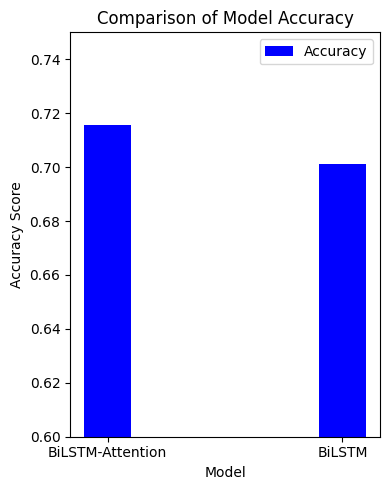

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['BiLSTM-Attention', 'BiLSTM']
accuracy_scores = [0.7156, 0.7013]  # example accuracy scores

x = np.arange(len(models))  # the label locations
width = 0.20  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(4,5))

accuracy_bars = ax.bar(x, accuracy_scores, width, label='Accuracy', color='b')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylim(0.6, 0.75)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy Score')
ax.set_title('Comparison of Model Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()


fig.tight_layout()

plt.show()


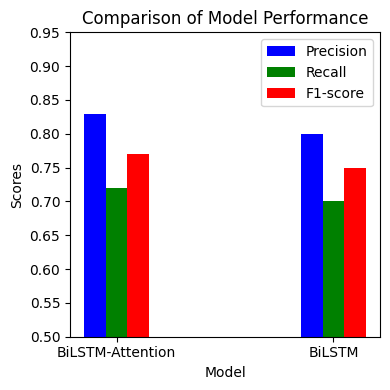

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['BiLSTM-Attention', 'BiLSTM']
metrics = ['Precision', 'Recall', 'F1-score']
precision_scores = [0.83, 0.80]
recall_scores = [0.72, 0.70]
f1_scores = [0.77, 0.75]

x = np.arange(len(models))  # the label locations
width = 0.10  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(4, 4))

precision_bars = ax.bar(x - width, precision_scores, width, label='Precision', color='b')
recall_bars = ax.bar(x, recall_scores, width, label='Recall', color='g')
f1_bars = ax.bar(x + width, f1_scores, width, label='F1-score', color='r')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylim(0.5, 0.95)
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

fig.tight_layout()

plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, Input, Concatenate, Dot
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.layers import Activation, RepeatVector, Permute, multiply, Lambda
from keras import backend as K


def create_model_with_attention(embedding_matrix, max_seq_length):
    input_layer = Input(shape=(max_seq_length,))
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                input_length=max_seq_length,
                                weights=[embedding_matrix],
                                trainable=True)(input_layer)
    dropout_emb = Dropout(0.2)(embedding_layer)

    # Attention Mechanism
    attention = TimeDistributed(Dense(1, activation='relu'))(dropout_emb)
    attention = Activation('softmax')(attention)

    # Apply attention weights
    sent_representation = multiply([dropout_emb, attention])
    lstm = Bidirectional(LSTM(units=100, return_sequences=True))(sent_representation)


    # Self-Attention Mechanism
    self_attention = Dot(axes=[2, 2])([lstm, lstm])
    self_attention = Activation('softmax')(self_attention)

    # Combine attention and self-attention
    combined_attention = Concatenate(axis=-1)([lstm, self_attention])

    # Feedforward layer
    output = TimeDistributed(Dense(128, activation='relu'))(combined_attention)
    output = Dropout(0.2)(output)
    output = TimeDistributed(Dense(3, activation='softmax'))(output)  # Assuming 3 classes: 'O', 'B', 'I'

    model = Model(inputs=input_layer, outputs=output)

    return model

# Create and compile the model with attention mechanisms
model_attention = create_model_with_attention(embedding_matrix, max_seq_length)
model_attention.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_attention = model_attention.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20, callbacks=[early_stopping])

# Evaluate the model on test data
loss, accuracy = model_attention.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred_attention = model_attention.predict(X_test)

# Convert one-hot encoded predictions to class labels
y_pred_labels_attention = np.argmax(y_pred_attention, axis=-1)
y_true_labels = np.argmax(y_test, axis=-1)

report_attention = classification_report(y_true_labels.flatten(), y_pred_labels_attention.flatten(), labels=[0, 1, 2], target_names=['O', 'B', 'I'])
print(report_attention)


Epoch 1/20
46/46 [==============================] - 16s 245ms/step - loss: 0.2783 - accuracy: 0.9408 - val_loss: 0.0832 - val_accuracy: 0.9664
Epoch 2/20
46/46 [==============================] - 9s 203ms/step - loss: 0.0728 - accuracy: 0.9726 - val_loss: 0.0669 - val_accuracy: 0.9730
Epoch 3/20
46/46 [==============================] - 10s 218ms/step - loss: 0.0557 - accuracy: 0.9790 - val_loss: 0.0585 - val_accuracy: 0.9767
Epoch 4/20
46/46 [==============================] - 10s 223ms/step - loss: 0.0448 - accuracy: 0.9834 - val_loss: 0.0550 - val_accuracy: 0.9788
Epoch 5/20
46/46 [==============================] - 11s 237ms/step - loss: 0.0384 - accuracy: 0.9857 - val_loss: 0.0528 - val_accuracy: 0.9806
Epoch 6/20
46/46 [==============================] - 8s 185ms/step - loss: 0.0327 - accuracy: 0.9881 - val_loss: 0.0533 - val_accuracy: 0.9810
Epoch 7/20
46/46 [==============================] - 10s 222ms/step - loss: 0.0282 - accuracy: 0.9897 - val_loss: 0.0522 - val_accuracy: 0.9824
E

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Parse the classification report to extract precision, recall, and F1-score
report_lines = report_attention.split('\n')
class_labels = ['O', 'B', 'I']
metrics = []

# Skip header and footer, then iterate through each line
for line in report_lines[2:-5]:
    values = line.strip().split()
    class_metric = dict(zip(['precision', 'recall', 'f1-score', 'support'], map(float, values[1:])))
    metrics.append(class_metric)

# Compute the overall precision, recall, and F1-score
overall_precision = sum(metric['precision'] * metric['support'] for metric in metrics) / sum(metric['support'] for metric in metrics)
overall_recall = sum(metric['recall'] * metric['support'] for metric in metrics) / sum(metric['support'] for metric in metrics)
overall_f1_score = sum(metric['f1-score'] * metric['support'] for metric in metrics) / sum(metric['support'] for metric in metrics)

print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1-score:", overall_f1_score)


Overall Precision: 0.9769214111072303
Overall Recall: 0.9796046105483759
Overall F1-score: 0.9781585749214111


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels.flatten(),y_pred_labels_attention.flatten(), labels=[0, 1, 2], average='weighted')

print("Overall Precision:", precision)
print("Overall Recall:", recall)
print("Overall F1-score:", f1_score)

Overall Precision: 0.9821321573197582
Overall Recall: 0.9823611596227733
Overall F1-score: 0.9820899802484615
